## TD METHODS

In DP methods, we found optimal policies. But, we used ```transition_map``` to do that. This is quite impractical. There are many reasons for that:

- We don't know all the states we can visit
- Environment dynamics can be unknown
- Iterating over all states can be computationally infeasible

In this notebook, we will be practicing over TD methods. Instead of calculating the exact value, we will get samples and estimate the value over samples. One approach that comes into our minds, when we talk about sampling, is **Monte Carlo** method. MC method is the first algorithm we will be implementing.

**MC** estimation and control is pretty simple. We sample trajectories from the environment by following a policy $\pi$ and calculate the returns of each state we visit.

**Question 1)** How can you ensure that we visit (sample) enough states to find an optimal policy?

It is not yet formally proven (Tsitsiklis, 2002) how many samples are required or which samples has to be visited to find an optimal policy. Some techniques are developed over the year to solve this issue by exploration-exploitation dillemma. In example, with epsilon-greedy algorithm, as training time passes, the exploration amount decreases and exploitation increases.

#### Environment

We will be using a new environment called **Warehouse** where an agent tries to match each item with the corresponding box. Building a transition map for this environment would be painful. Luckily, we don't need to build that in TD methods. The ```worldmap``` is given below (you can modify this for fun but, we will be using the one below to evaluate).

You can run the cell below to visualize the environment.
- <span style="color:#989898">Dark gray cells</span> are impassable cells.
- <span style="color:#DADADA">light gray cells</span> are passable empty cells.
- <span style="color:#00B8FA">Blue cell</span> is the agent.
- <span style="color:#A33675"> Darker magenta cell </span> and <span style="color:#48C69F"> darker green cell </span> are items to collect. 
- <span style="color:#B34685"> Lighter magenta cell </span> and <span style="color:#58D6AF"> lighter green cell </span> are the boxes.

Pairing is also given below. A key in the pairing dictionary is a box(uppercase) and its corresponding value is a list of items(lowercase) that can be delivered to that box.

State representation is different here. Instead of giving just the position of the agent, we have 4 more additional features. These are 4 boolean values for two items and two boxes.  The boolean feature is true if the item or the box exists on the map and false otherwise. When the bucket receives the item it disappears.

In [2]:
%load_ext autoreload
%autoreload 2

from rl_hw1.env import Warehouse

worldmap = ["#########",
            "#   #   #",
            "# c # C #",
            "#   #   #",
            "#   P   #",
            "#   #   #",
            "# b # B #",
            "#   #   #",
            "#########"]

# buckets are Uppercase letters while balls are lowercase
# matching is done so that the ball "b" must be carried to the bucket "B"
pairing = {
    "B": ["b"],
    "C": ["c"]
}

env = Warehouse(balls="cb", buckets="BC", pairing=pairing, worldmap=worldmap)
env.init_render()

/home/resul/anaconda3/envs/drl/lib/python3.7/site-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


**Question 2)** In the ```rl_hw1/learning/monte_carlo.py``` module, implement ```MonteCarloAgent```



Let's train the ```MonteCarloAgent``` using the training loop given below. You can tune hyperparameters (```args```) given below. ```args``` is a namedtuple built from the dictionary initialized between lines 10 and 18. 

**Question 3)** Train the ```MonteCarloAgent``` by tuning the hyperparameters. For all of your implementations (MC, Q learning, Sarsa) your agent should get at least **1.5** episodic reward (sum of rewards throughout an episode).

In [26]:
from rl_hw1.learning import MonteCarloAgent
from collections import namedtuple
import numpy as np
import random

# initialize agent
agent = MonteCarloAgent(nact=4)

# hyperparameters
args = dict(
    iteration = 900,
    gamma = 0.98,
    alpha = 0.15,
    init_eps = 0.9,
    final_eps = 0.1,
    eps_decay_rate = 0.999,
    seed = 12021,            # current year: (10000 + 2021 = 12021) Holocene calendar
)
args = namedtuple('args', args.keys())(*args.values()) 

# seed
np.random.seed(args.seed)
random.seed(args.seed)

# traning loop
reward_list = []
epsilon = args.init_eps

for ix in range(args.iteration):
    epsilon = max(args.final_eps, epsilon*args.eps_decay_rate)
    
    reward = agent.one_episode_train(env, lambda x: agent.e_greedy_policy(x, epsilon), args.gamma, args.alpha)
    reward_list.append(reward)
    
    if ((ix + 1) % 50) == 0:
        print("Episode: {}, reward: {}".format(ix + 1, np.mean(reward_list[-100:])))

Episode: 50, reward: 0.34
Episode: 100, reward: 0.53
Episode: 150, reward: 0.92
Episode: 200, reward: 1.39
Episode: 250, reward: 1.69
Episode: 300, reward: 1.73
Episode: 350, reward: 1.79
Episode: 400, reward: 1.85
Episode: 450, reward: 1.88
Episode: 500, reward: 1.92
Episode: 550, reward: 1.96
Episode: 600, reward: 1.97
Episode: 650, reward: 1.95
Episode: 700, reward: 1.96
Episode: 750, reward: 1.99
Episode: 800, reward: 1.97
Episode: 850, reward: 1.96
Episode: 900, reward: 1.95


Now, let's try to render the trained agent. Run the followwing cells below.

In [27]:
env = Warehouse(balls="cb", buckets="BC", pairing=pairing, worldmap=worldmap)
env.init_render()

In [28]:
# you can run this cell to visualize the agent as many times as you wish.
agent.evaluate(env, render=True)

0.0

MC method waits until the episode is terminated to begin the update. But, is it possible to update the policy within every transition? Temporal Difference (TD) methods exactly aim for this. There are two popular TD methods that you will be implementing: Q Learning and SARSA.

**Question 3)** What is the difference between off-policy and on-policy algorithms?

Off-policy algorithms do evaluation and update of the policy which is different from the policy that is used to generate episode transitions. On the other hand, on-policy algorithms do evaluation and update of the policy that is used to generate episode transitions.


### Q - Learning

Q learning is an off-policy algorithm that employs temporal difference value estimation.

**Question 4)** What makes Q learning an off-policy algorithm? Why don't we use importance sampling in Q learning?

Because the learned value function is defined under the __target policy__ that is used to generate data, a Q learning method automatically becomes an off-policy algorithm. In order to transform behaviors of expectations from learning policy to the target policy, by taking the ratio of action probabilities, __importance sampling__ techniques are used.

**Question 5)**  In the ```rl_hw1/learning/td.py``` module, implement ```QAgent```

In [49]:
from collections import namedtuple
import numpy as np
import random
import matplotlib.pyplot as plt

from rl_hw1.learning import QAgent, SarsaAgent


# initiate environment
env = Warehouse(balls="cb", buckets="BC", pairing=pairing, worldmap=worldmap)

# initialize agent
q_agent = QAgent(nact=4)

# hyperparameters
args = dict(
    episodes = 2500,
    evaluate_period = 50,
    gamma = 0.92,
    alpha = 0.08,
    init_eps = 0.9,
    final_eps = 0.05,
    eps_decay_rate = 0.9995,
    seed = 12021,            # current year: (10000 + 2021 = 12021) Holocene calendar
)
args = namedtuple('args', args.keys())(*args.values()) 

# seed
np.random.seed(args.seed)
random.seed(args.seed)

q_rewards = q_agent.train(env, q_agent.e_greedy_policy, args)

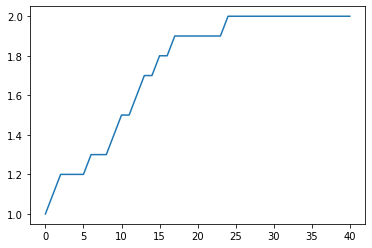

In [50]:
%matplotlib inline
plt.plot(np.convolve(q_rewards, np.ones(10) / 10, "valid"))
plt.show()

In [51]:
env.init_render()

In [52]:
# you can run this cell to visualize the agent as many times as you wish.
q_agent.evaluate(env, render=True)

2.0

You implemented an off-policy TD(Temporal Difference) Learning algorithm. Now, try to implement SARSA. You can find the pseudocode in the 6th chapter of Reinforcement Learning Book (Sutton & Barta).

**Question 6)** What makes SARSA an on-policy algorithm?

During updating __action-value function__, SARSA algorithm used current policy's action and next state pairs, so that this makes SARSA an on-policy algorithm.

**Question 7)** In the ```rl_hw1/learning/td.py``` module, implement ```SarsaAgent```

**Question 8)** Write down a training loop similar to what we did for Q learning to test your ```SarsaAgent```

In [77]:
# Sarsa training loop

from collections import namedtuple
import numpy as np
import random
import matplotlib.pyplot as plt

from rl_hw1.learning import SarsaAgent


# initiate environment
env = Warehouse(balls="cb", buckets="BC", pairing=pairing, worldmap=worldmap)

# initialize agent
sarsa_agent = SarsaAgent(nact=4)

# hyperparameters
args = dict(
    episodes = 1900,
    evaluate_period = 50,
    gamma = 0.5,
    alpha = 0.2,
    init_eps = 0.9,
    final_eps = 0.2,
    eps_decay_rate = 0.9995,
    seed = 12021,            # current year: (10000 + 2021 = 12021) Holocene calendar
)
args = namedtuple('args', args.keys())(*args.values()) 

# seed
np.random.seed(args.seed)
random.seed(args.seed)

sarsa_rewards = sarsa_agent.train(env, sarsa_agent.e_greedy_policy, args)

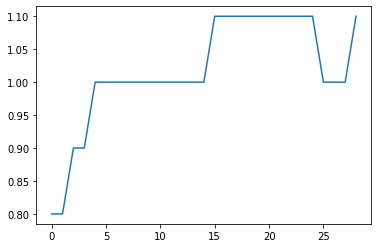

In [78]:
# Sarsa reward visualization

%matplotlib inline
plt.plot(np.convolve(sarsa_rewards, np.ones(10) / 10, "valid"))
plt.show()

In [79]:
# Sarsa visualization

env.init_render()

In [80]:
sarsa_agent.evaluate(env, render=True)

2.0

**Question 9)** Compare MC and TD based methods. When would you prefer one over the other?

Monte-Carlo method is a trial-based learning method, where MDP without probability transactions could be estimated with trial-errors with many repetitions. Optimization and updating part is done only when an episode is terminated with total return $G_t$. The problem or disadvantage with MC method is that the update of a value function could only be done after an episode is finished or terminated. On the other hand, temporal-difference methods should not wait until episode is terminated, these methods could optimize state-value $V_\pi(s)$ or action-value $Q_\pi(s, a)$ functions after each step.

MC method can be used when actual episodic return $G_t$ could be computed, while TD method can be used when an estimated episodic return $R_{t+1} + V(S_{t+1})$ could be computed. In TD method there is no need to know an accurate return from the episode, by using the Bellman Optimality equation, an estimate of the value from the episode could be calculated.

**Question 10)** Can you think of an algorithm that combines the advantages of MC and TD methods. Write down a **simple**  pseudocode.

#### Approximate Methods

We have seen different ways to estimate value, however, until now we only worked on tabular representations. But almost always states are represented by vectors. In this part of the homework, you will be working on linear representations that can work with continuous state spaces.

We can use any function to represent values as long as it returns a single scalar value for a state-action pair. For simplicity, we will be using a linear function. Function approximation methods can be used in both Sarsa and Q learning. In this homework, we will be implementing function approximation with Q learning.

You can find a similar algorithm within the pseudocode at **chapter 9.3 in Reinforcement Learning Book (Sutton & Barto)**. These methods are called **semi-gradient** methods. The reason is that we do not take the gradient of the loss term (mean squared TD) with respect to both functions $Q(s,a)$ and $\max_i Q(s', a_i)$.

Please read the relevant section

**Question 11)** In tabular settings, whenever we update the value of a particular state action pair $(s, a)$, only a single value changes. What are your thoughts about the value changes in approximate settings after an update? How is it different than the tabular case? 

In this part of the homework, we will be using the **CartPole** environment. It is a continuous state, discrete action environment. You can check it out from [Open AI gym](https://gym.openai.com/envs/CartPole-v0/) for more details.

**Question 12)** We will be using a linear function. However, we still need to have some features over raw observation. Complete the implementation of the wrapper below.

In [84]:
from gym import ObservationWrapper
from gym.spaces import Box


class FeaturedObservation(ObservationWrapper):
    """
        Create feature vectors that are randomly scattered in the observation space.
        Instead of returning the raw state(observation) return features. The feature matrix is a KxN matrix
        where K denotes the number of features while N denotes raw state space size.
        Each row in the Feature matrix represents a feature in the state space.
        
        F(S): R^{N} -> R^{K}  
        
        Returned vector is simply a dot product between each feature vector and the observed state(observation).
        
        Arguments:
            - env: gym environment
            - n_features: Number of features
    """

    def __init__(self, env, n_features):
        super().__init__(env)
        
        self.features = np.random.uniform( -0.4, 0.4, size=(n_features, env.observation_space.shape[0]))
        
        _low = env.observation_space.low.min()
        _high = env.observation_space.high.max()

        _dtype = env.observation_space.dtype
        
        self.observation_space  = Box(low=_low, high=_high, shape=(n_features, ), dtype=_dtype)

    def observation(self, observation):
        """
            Return features of the obervation using matrix multiplication.
        """
        
        return np.dot(self.features, observation)

**Question 13)** In the ```rl_hw1/learning/approximate.py``` module, implement ```ApproximateAgent``` & ```ApproximateQAgent```

**Question 14)** Run the approximate q learning agent by tuning the hyperparameters (```args```) given below.

In [97]:
from collections import namedtuple
import numpy as np
import random
import gym
import matplotlib.pyplot as plt

from rl_hw1.learning import ApproximateQAgent

# hyperparameters
args = dict(
    episodes = 12000,
    evaluate_period = 250,
    n_features = 64,
    gamma = 0.98,
    alpha = 0.00001,
    init_eps = 0.9,
    final_eps = 0.05,
    eps_decay_rate = 0.99999,
    seed = 12021,            # current year: (10000 + 2021 = 12021) Holocene calendar
)
args = namedtuple('args', args.keys())(*args.values())

# initiate environment
env = gym.make("CartPole-v1")

# seed
env.seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

# wrap the environment
env = FeaturedObservation(env, args.n_features)

# initialize agent
appx_q_agent = ApproximateQAgent(
    nobs = env.observation_space.shape[0],
    nact = env.action_space.n
)

appx_q_rewards, appx_q_losses = appx_q_agent.train(env, appx_q_agent.e_greedy_policy, args)

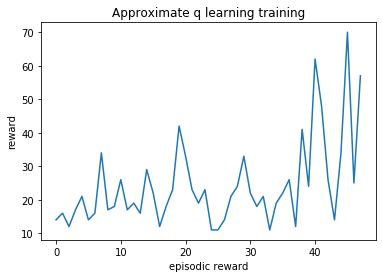

In [98]:
plt.title("Approximate q learning training")
plt.xlabel("episodic reward")
plt.ylabel("reward")
plt.plot(appx_q_rewards)

Now evaluate your agent. We expect to see at least **100** episodic reward in average.

In [99]:
# you can run this cell to visualize the agent
# if you run evaluation with render from docker it may not work!!
appx_q_agent.evaluate(env, render=True)

166.0

In [100]:
appx_q_agent_rewards = [appx_q_agent.evaluate(env, render=False) for i in range(100)]

print("Average episodic reward: {:.4}, Deviation: {:.4}".
      format(np.mean(appx_q_agent_rewards), np.std(appx_q_agent_rewards)))

Average episodic reward: 151.6, Deviation: 30.19
